# Error versus information

In [1]:
using Statistics, StatsBase, BitInformation
using JLD2, NetCDF

path = "/network/aopp/chaos/pred/kloewer/esowc/cams/"
filelist = filter(x->endswith(x,"_v3.nc"),readdir(path));

┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1317


In [12]:
# pick only some variables
vars = ["o3","co2","co","aerlg","aermr03","aermr06","ch4","no","no2","so2","q"]
nvars = length(vars)
varnames = fill("",nvars)

# round to
keepbits = collect(1:20)
nkeepbits = length(keepbits)

# preallocation
dec_error = fill(0f0,nvars,nkeepbits)
pres_info = fill(0.0,nvars,nkeepbits)

ivar = 0
for (i,file) in enumerate(filelist)
    varname = split(split(file,"cams_")[end],"_2019")[1]
    
    if varname in vars
        ivar += 1
        varnames[ivar] = varname
        print("$varname ")
        ncfile = NetCDF.open(joinpath(path,file))
    
        # find the variable name by size
        var = [var for var in ncfile.vars if prod(size(var[2])) == 900*451*137][1][1]
        X = ncfile.vars[var][:,:,:]    # exclude soutpole & northpole    

        # BITINFORMATION
        bi = bitinformation(X,:all_dimensions)
        print("B")
        
        for (k,keepbit) in enumerate(keepbits)
            print("$k")
            Xr = shave(X,keepbit)
                        
            # PRESERVED INFORMATION
            R = redundancy(X,Xr)
            pres_info[ivar,k] = (R'*bi)/sum(bi)*100
        
            # DECIMAL ERROR
            decerr = abs.(log10.(abs.(X./Xr)))

            decerr = sort(vec(decerr))
            dec_error[ivar,k] = quantile(decerr,.5,sorted=true)
        end
        print("\n")
    end
end

@save joinpath(path,"..","analysis/error_vs_info.jld2") varnames keepbits dec_error pres_info

aerlg B1234567891011121314151617181920
aermr03 B1234567891011121314151617181920
aermr06 B1234567891011121314151617181920
ch4 B1234567891011121314151617181920
co2 B1234567891011121314151617181920
co B1234567891011121314151617181920
no2 B1234567891011121314151617181920
no B1234567891011121314151617181920
o3 B1234567891011121314151617181920
q B1234567891011121314151617181920
so2 B1234567891011121314151617181920


In [2]:
@load joinpath(path,"..","analysis/error_vs_info.jld2") varnames keepbits dec_error pres_info
nvars = length(varnames)

11

## PLOT

In [3]:
using PyPlot
using PyCall
mticker = pyimport("matplotlib.ticker")
FormatStrFormatter = mticker.FormatStrFormatter;

In [4]:
lost_info = 100 .- pres_info;

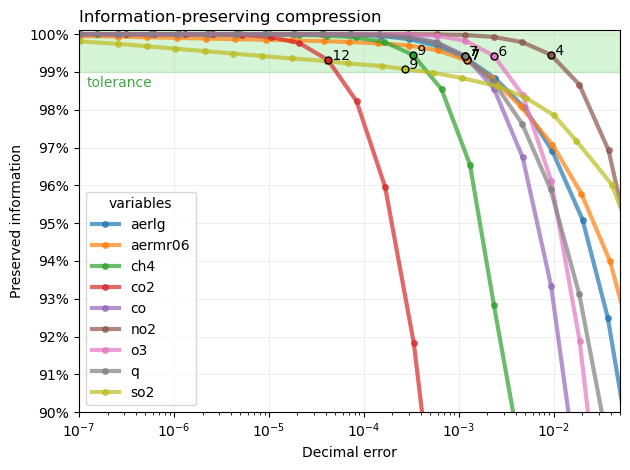

In [22]:
fig,ax = subplots(1,1)

for i in vcat(1,3:7,9:11)
    ax.semilogx(dec_error[i,:],pres_info[i,:],"o-",label=varnames[i],ms=4,alpha=0.7,lw=3)
    k99 = argmax(pres_info[i,:] .> 99)
    ax.scatter(dec_error[i,k99],pres_info[i,k99],25,edgecolor="k",zorder=10)
    ax.text(dec_error[i,k99],pres_info[i,k99]," $k99")
end

ax.legend(loc=3,title="variables")
ax.set_ylabel("Preserved information")
ax.set_xlabel("Decimal error")

ax.set_ylim(90,100.1)
ax.set_xlim(1e-7,5e-2)
ax.set_yticks(90:100)
ax.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
ax.grid(alpha=.2)

# tolerance
ax.fill_between(ax.get_xlim(),[99,99],[101,101],color="limegreen",alpha=.2)
ax.text(1.2e-7,98.9,"tolerance",color="C2",alpha=.9,va="top")

ax.set_title("Information-preserving compression",loc="left")
tight_layout()

__Entropy__ for a bitstream $b = b_1b_2b_3 ...b_j... b_n$

$$ H(b) = -\sum_{i=0,1}p_i \log_2(p_i)$$

with propabilities $p_0,p_1$ for a bit in $b$ being 0 or 1, respectively.

__Real information__ for a bitstream $b$

$$ I(b) = H(b) - q_0H_0 - q_1H_1$$

with $H_0,H_1$ the conditional entropies based on state of the previous bit $b_{j-1}$ being $0,1$, respectively.

__Mutual information__ of two bitstreams $a,b$

$$M(a,b) = \sum p_{ab} \log_2 \left(\frac{p_{ab}}{p_a p_b} \right) $$

where $p_{ab}$ is the joint propability of $a$ and $b$, and $p_a$, $p_b$ the respective marginal probabilities of $p_{ab}$.

__Redundancy__ of two bitstreams $a,b$ is

$$R(a,b) = \frac{2M}{H(a) + H(b)}$$

and 1 for $a = b$ and 0 for $a$ being entirely independent of $b$.

__Preserved information__ of an arrays $X = (x_1,x_2,...x_n)$ in $Y = (y_1,y_2,...,y_n)$ is based on the bitwise real information $I(X)_k$ in $X$ and the bitwise redundancy $R(X,Y)$ between $X$ and $Y$

$$P(X,Y) = \frac{\sum_k R(X,Y)_k I(X)_k}{\sum_k I(X)_k}$$.

The preserved information is the redundancy-weighted mean of the real information in $X$.

__Information loss__ is

$$ L(X,Y) = 1-P(X,Y)$$

the unpreserved information of $X$ in $Y$.